# House Prices With Advanced Feature Engineering


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
# from scipy.stats.mstats import winsorize

# Overview

In [5]:
# Data set documentation
house_data_description = open('./data/data_description.txt')
text = house_data_description.read()
print(text)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [6]:
#a brief look at the dataset
houses_train = pd.read_csv('./data/train.csv')
houses_test = pd.read_csv('./data/test.csv')

original_numerical_features = houses_test.select_dtypes(include=np.number).columns.to_list()
original_categorical_features = houses_test.select_dtypes(exclude=np.number).columns.to_list()


print(f"shape of test: {houses_train.shape}")
print(f"shape of test: {houses_test.shape}")
houses_train.head()

shape of test: (1460, 81)
shape of test: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
#splitting features to categorical and numerical
categorical = houses_train.dtypes[(houses_train.dtypes==object)].index
numerical = houses_train.dtypes[(houses_train.dtypes!=object)].index[1:-1] #omitting id and SalePrice (first and last dtypes respectively)

print(f"Numerical features: {numerical.size}")
print(f"Categorical features: {categorical.size}")

Numerical features: 36
Categorical features: 43


# SalePrice statistic

First, we would like to understand the distribution describing the target variable. We aim to work with normaly distributed variables (target and features) because then, methods that are non-invariant to standartization such as LASSO or ridge regression should work more properly.
Also, for sake of interpertability, validity of measures of association (such as correlations), and insensitivity to the features scales, the different variables should be normalized.  

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


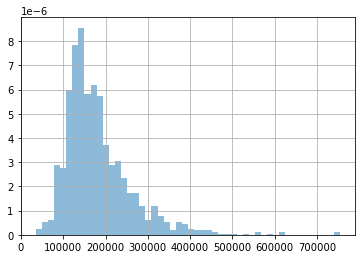

In [8]:
print(houses_train['SalePrice'].describe())
print(f"Skewness: {houses_train['SalePrice'].skew()}")
print(f"Kurtosis: {houses_train['SalePrice'].kurt()}")
houses_train['SalePrice'].hist(bins=50, density=True, alpha=0.5);

Lets try the normal and log-normal for the target:

C:\Users\noybu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\noybu\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness_norm: -0.014957435566490035
Kurtosis_norm: 0.13354557646993692
Skewness_Log norm: 0.1212103673013655
Kurtosis_Log norm: 0.8026555069117713


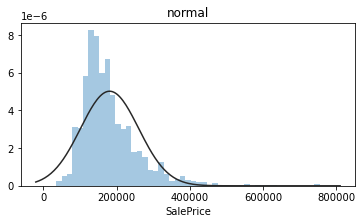

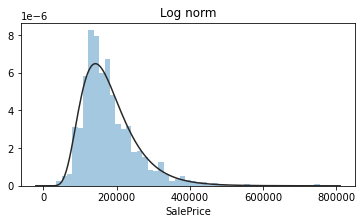

In [9]:
mu = np.mean(houses_train['SalePrice'])
sigma = np.std(houses_train['SalePrice'])
norm = np.random.normal(mu, sigma, houses_train['SalePrice'].shape)

plt.figure(figsize=(6, 3))
sns.distplot(houses_train['SalePrice'],kde=False,fit=scipy.stats.norm)
plt.title("normal")
print("Skewness_norm:", scipy.stats.skew(norm))
print("Kurtosis_norm:", scipy.stats.kurtosis(norm))


log_sp = np.log(houses_train['SalePrice'])
plt.figure(figsize=(6, 3),)
sns.distplot(houses_train['SalePrice'], kde=False, fit=scipy.stats.lognorm)
plt.title("Log norm")
print("Skewness_Log norm:", scipy.stats.skew(log_sp))
print("Kurtosis_Log norm:", scipy.stats.kurtosis(log_sp))

In [10]:
houses_train["SalePrice_log"] = log_sp

Seems more like a log normal distribution


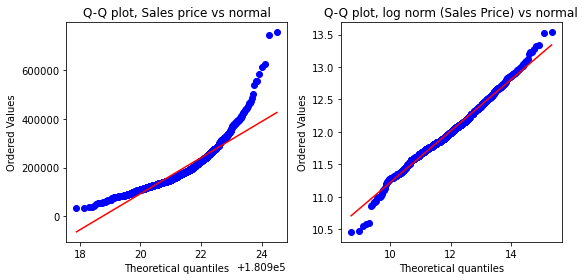

In [11]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
scipy.stats.probplot(houses_train['SalePrice'], dist=scipy.stats.norm, sparams=(houses_train['SalePrice'].mean()), plot=plt)
plt.title('Q-Q plot, Sales price vs normal')
plt.subplot(1,2,2)
scipy.stats.probplot(log_sp, dist=scipy.stats.norm, sparams=(log_sp.mean()), plot=plt,)
plt.title('Q-Q plot, log norm (Sales Price) vs normal');
plt.tight_layout()

# Features

##### outliers
A common method to define outliers is the “3 times the standard deviation” rule. For now, we will use this method and replace all the exceptional values with lower_limit/upper_limits defined by 3std with respect to the feature mean.
We also apply the same approuch on the test using the mean and std calculated from the train.

In [12]:

for col in list(numerical):
    mean_col = houses_train[col].mean()
    std_col = houses_train[col].std()
    lower_limit = mean_col - 3*std_col
    upper_limit = mean_col + 3*std_col
    houses_train[col] = pd.Series([min(max(a,lower_limit),upper_limit) for a in houses_train[col]])
    houses_test[col] = pd.Series([min(max(a,lower_limit),upper_limit) for a in houses_test[col]])


Now lets move on to examine the features. First. how many NAs do we have?

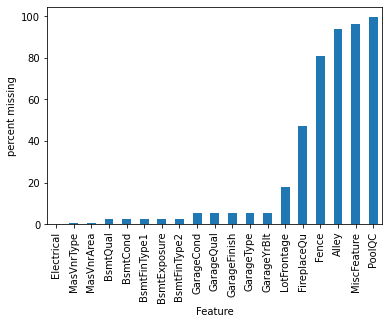

In [13]:
#for train
missing_train = houses_train.isnull().sum()*100/len(houses_train)
missing_train = missing_train[missing_train > 0]
missing_train.sort_values(inplace=True)
missing_train.plot.bar()
plt.xlabel("Feature")
plt.ylabel("percent missing")
plt.show();
#for test
missing_test = houses_test.isnull().sum()*100/len(houses_train)
missing_test = missing_test[missing_test > 0]
missing_test.sort_values(inplace=True)

In [14]:
missing = set(missing_train.index).union(set(missing_test.index))

Some features have large portions of NAs, But these are not actually missing values as they reprecent the absence of a house characraristic such as not having a pool (PoolQC, Alley etc.). However the MiscFeature which describe the present of some special charactaristics (such as 2nd garage, elevator etc.) could be discarded entirely as those few special features are not comparable...  


For numerical data we can later fill in the missing values with columns averages. For categorical, we can change to `None`

We should note that, when filling in the missing values with averages, we are not affecting the average, but are affecting the general distribution, and that should be taken into consideration.

In [15]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fill_with_none = [col for col in missing if col in categorical]
cols_fill_with_average = [col for col in missing if col in numerical]
# replace 'NaN' with 'None' in these columns
for col in cols_fill_with_none:
    houses_train[col].fillna("None",inplace=True)
    houses_test[col].fillna("None",inplace=True)
    
for col in cols_fill_with_average:
    houses_train[col].fillna(houses_train[col].mean(),inplace=True)
    houses_test[col].fillna(houses_test[col].mean(),inplace=True)

# Correlations

First, we will examine the correlation between the independent variables and the dependent variable (our target) and among themselves. we will test quantitative features first.

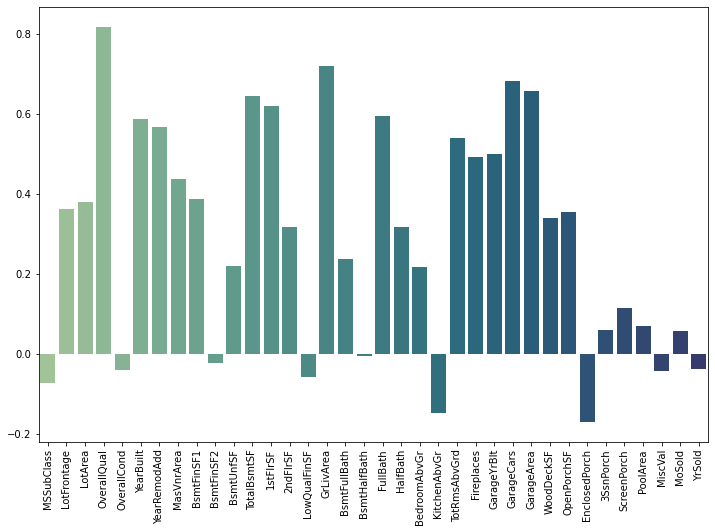

In [16]:
cols = list(numerical) + ["SalePrice_log"]

corrs = houses_train[cols].corr()["SalePrice_log"]
fig, ax = plt.subplots(figsize=(12, 8))
g = sns.barplot(
    x=corrs[:-1].index,
    y=corrs[:-1].values, palette="crest")
plt.xticks(rotation=90)
plt.show();

Looking at the correlations between SalePrice and numerical features, we can see that setting a threshold of absolute value of $|R|=0.4$ will maintain about half of the features. 

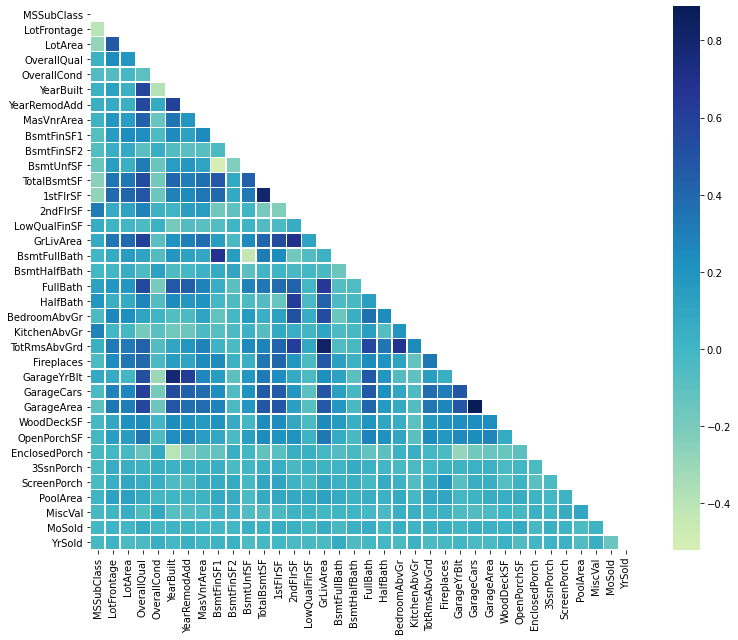

In [17]:
correlations = houses_train[numerical].corr()
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(correlations, mask=mask, center=0,
            square=True, linewidths=.5,cmap="YlGnBu")        
plt.show()

We can see that some features are highly correlated. We shall consider remove some of features in training to avoid multicolinearity

As mentioned above, we shall also try to work with normaly distributed features

In [18]:
normal_data = pd.concat([pd.Series(houses_train[numerical].kurt(),name="Kurtosis"),pd.Series(houses_train[numerical].skew(),name="Skewness")],axis=1)
normal_data

,Kurtosis,Skewness
MSSubClass,1.406664,1.368878
LotFrontage,2.080783,0.531372
LotArea,12.514219,2.716906
OverallQual,-0.009919,0.248222
OverallCond,0.876145,0.728585
YearBuilt,-0.472936,-0.605624
YearRemodAdd,-1.272245,-0.503562
MasVnrArea,2.635188,1.791767
BsmtFinSF1,-0.231755,0.746550
BsmtFinSF2,9.291040,3.245254


By examining the kurtosis and skewness, we can find variables which their original distribution is far from normal. We would hope to normalize those. Lets try the lognormal (and specificaly focus on variables that are right now far from being normal such as LotArea, 3SsnPorch, PoolArea etc.).

In [19]:
log_house_train = np.log(houses_train[numerical]+0.001)
log_normal_data = pd.concat([pd.Series(log_house_train[numerical].kurt(),name="Kurtosis"),pd.Series(log_house_train[numerical].skew(),name="Skewness")],axis=1)
log_normal_data

,Kurtosis,Skewness
MSSubClass,-1.135062,0.224620
LotFrontage,3.094271,-1.155287
LotArea,2.603086,-0.719916
OverallQual,1.219737,-0.561527
OverallCond,2.179081,-0.204166
YearBuilt,-0.414741,-0.632693
YearRemodAdd,-1.263360,-0.511009
MasVnrArea,-1.823070,0.388752
BsmtFinSF1,-1.417959,-0.731690
BsmtFinSF2,3.999700,2.441936


Now Lets find that features for which taking log indeed improve

In [20]:
diff = abs(normal_data)-abs(log_normal_data)
diff[(diff.Kurtosis>1) & (diff.Skewness>0)]

,Kurtosis,Skewness
LotArea,9.911133,1.996990
BsmtFinSF2,5.291340,0.803318
LowQualFinSF,5.728015,0.334796
EnclosedPorch,2.861515,0.504004
3SsnPorch,2.189324,0.137534
ScreenPorch,1.540343,0.197349
MiscVal,36.354067,2.340390


Now lets keep the log of these features (and also keep in mind that some may not be relevant at all. e.g. MiscVal)

In [21]:
features_to_log = diff[(diff.Kurtosis>1) & (diff.Skewness>0)].index
for feature in features_to_log:
    houses_train[feature+"_log"]=np.log(houses_train[feature]+0.0001) # adding a small constant to avoid numerical instability
    houses_test[feature+"_log"]=np.log(houses_test[feature]+0.0001) # adding a small constant to avoid numerical instability

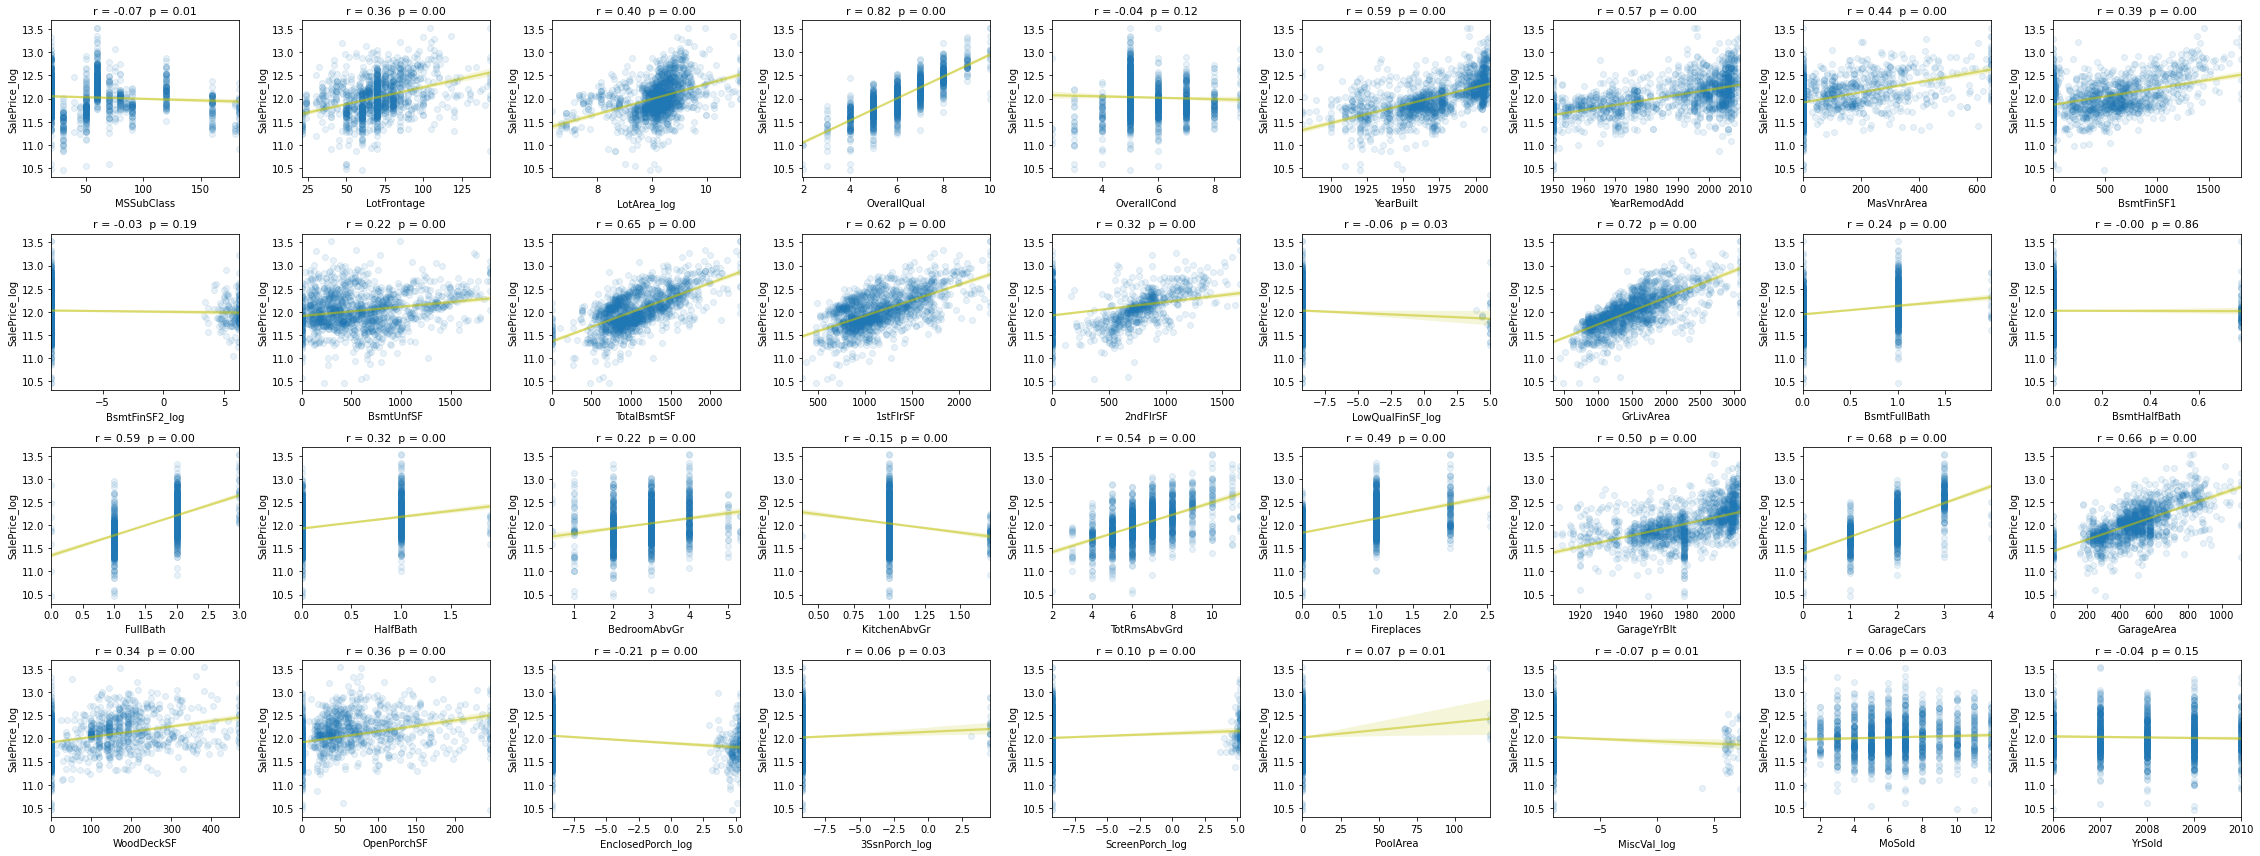

In [22]:
n_rows = 4
n_cols = 9

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5,n_rows*3))
li_num_feats = list(numerical)

for r in range(0, n_rows):
    for c in range(0, n_cols):  
        i = r * n_cols + c
        if i < len(li_num_feats):
            
            feature_to_plot = li_num_feats[i]
            if feature_to_plot+"_log" in houses_train.columns:
                
                feature_to_plot = feature_to_plot+"_log"
            sns.regplot(x=houses_train[feature_to_plot], y=houses_train["SalePrice_log"], ax = axs[r][c],  scatter_kws={"alpha": 0.1}, line_kws={"color": "y", "alpha": 0.5}
)
            stp = scipy.stats.pearsonr(houses_train[feature_to_plot], houses_train["SalePrice_log"])
            
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "  " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show() 


These above plots help a lot when determining the dependancy of the target variable in the different quantitative features.
We can look at the estimated slopes of the different fits. fits with small slopes values correspond to features in which the target variable is somewhant independant (e.g. MoSold, YrSold etc.). However, some features are clearly correlated with the target variable and may contribute later on when we try to build our LR model (e.g OverallQual, TotRmsAbvGrd). 


Now Lets explore our categorical fearues..
We can boxplot the target variable for each group in each categorical feature

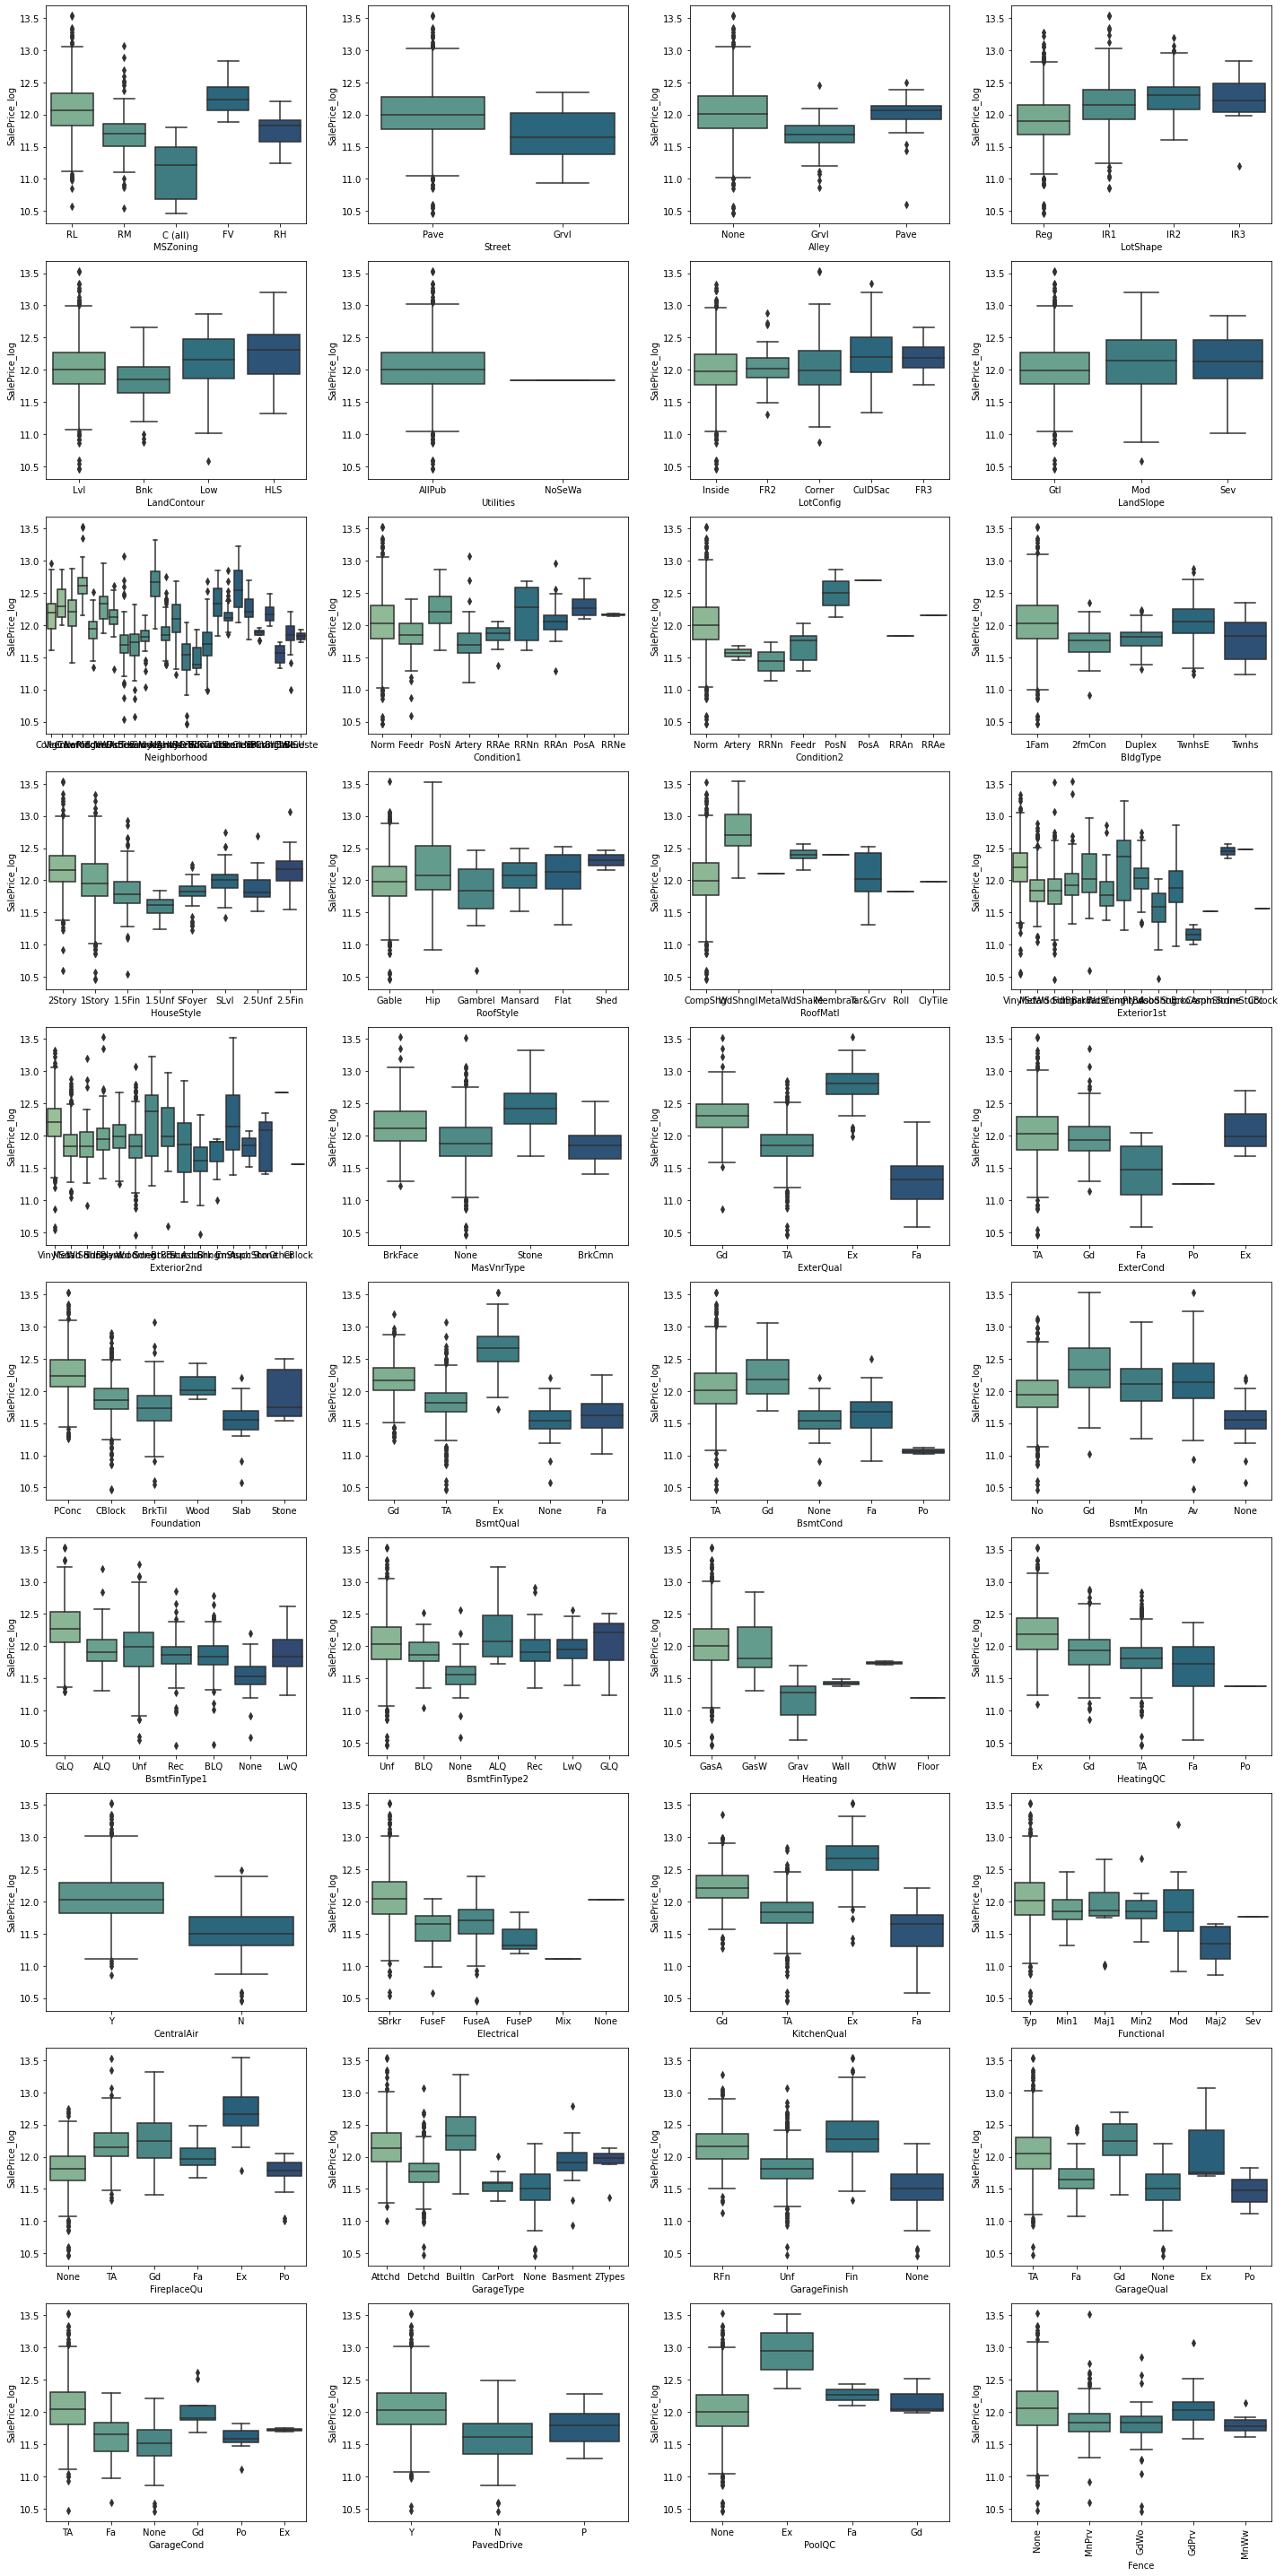

In [23]:
li_cat_feats = list(categorical)
nr_rows = 10
nr_cols = 4

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*4))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(data=houses_train, x=li_cat_feats[i], y="SalePrice_log", ax = axs[r][c], palette="crest")
            plt.xticks(rotation=90)
    
plt.tight_layout()    
plt.show()   

One can see that for some features the target variable distributions in different groups differ from each other quit a lot. Those will be good candidates for our model as the capture some of the variance in the target variable

Lets also print 2 box plots of critical numerical features

# Part 2

In [24]:
import sklearn
from sklearn import preprocessing
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [25]:
houses_train_modified = houses_train.copy()
houses_test_modified = houses_test.copy()

First, we want to factorize the categorical features so some basic techniques could handle them as numerical

In [26]:
for col in houses_train_modified[categorical]:
    grouped_target = houses_train_modified.groupby(col)["SalePrice"].mean().sort_values(ascending=True)
    factors = pd.factorize(grouped_target.index)[0]
    grouped_target = grouped_target.reset_index()
    grouped_target.drop("SalePrice",axis=1,inplace=True)
    grouped_target[col+"_fact"] = factors 
    houses_train_modified = pd.merge(left = houses_train_modified, right=grouped_target, on=col, how="left")
    houses_test_modified = pd.merge(left = houses_test_modified, right=grouped_target, on=col, how="left")
categorical_fact = categorical+'_fact'

In [27]:
numerical=houses_train_modified.select_dtypes(include=np.number).columns.to_list()
[numerical.remove(x) for x in ['Id','SalePrice_log', 'SalePrice']]

[None, None, None]

In [28]:
houses_test_modified[numerical]=houses_test_modified[numerical].fillna(-1) #handling categories abcsent from train
houses_train_modified = houses_train_modified[numerical] #without original categorical columns but with columns we created
houses_test_modified = houses_test_modified[numerical] #without original categorical columns but with columns we created

## Feature engineering

### K-means

We can try to cluster the datapoints and use the labels of the clusters as features. We may find it usefull later to also convert the arbitrary clusters' labels to factors corresponding to ranks oF the cluster mean SalePrice value as we did with existing categorical features. it is reasonable to combine different features that together could indicate the property total area to create a new feature that (intuitively) should be highly correlated with the target variable.

In [29]:
area_list = ["LotArea","TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea"]
area_features_df = houses_train_modified[area_list]

Before we do anything, we should determine the best possible k to cluster the data.
We can use elbow method to decide on that:

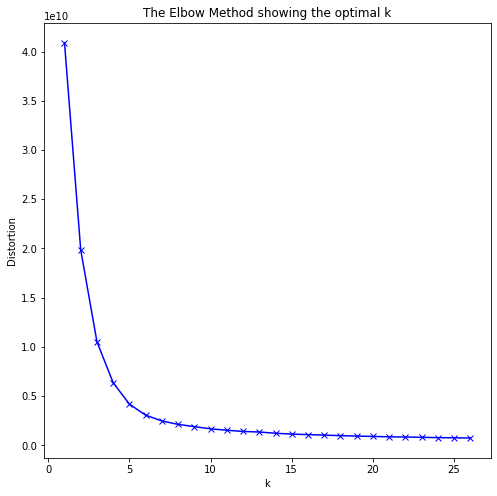

In [30]:
k_to_exmine = np.arange(1,int(np.sqrt(len(area_features_df)/2)))

distortions = []
for k in k_to_exmine:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(area_features_df)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(8,8))
plt.plot(k_to_exmine, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

based on elbow method we should use k=5.

In [31]:
km = KMeans(n_clusters=5)
houses_train_modified['area_label'] = km.fit_predict(area_features_df)
houses_test_modified['area_label'] =km.predict(houses_test_modified[area_list])

Creating a (SalePrice) sorted label feature:

In [32]:
train_full = pd.merge(left=houses_train_modified,right=houses_train[["SalePrice","SalePrice_log"]],
                      left_index=True,right_index=True) #adding columns "SalePrice","SalePrice_log"
grouped_target = train_full.groupby('area_label')["SalePrice"].mean().sort_values(ascending=True)

factors = pd.factorize(grouped_target.index)[0]
grouped_target = grouped_target.reset_index()
grouped_target.drop("SalePrice",axis=1,inplace=True)
grouped_target['area_label'+"_fact"] = factors 
houses_train_modified = pd.merge(left = houses_train_modified, right=grouped_target, on="area_label", how="left")
houses_test_modified = pd.merge(left = houses_test_modified, right=grouped_target, on="area_label", how="left")

houses_train_modified.drop("area_label",inplace=True,axis=1)
houses_test_modified.drop("area_label",inplace=True,axis=1)

#updating the numerical features with are new feature
numerical = numerical +["area_label_fact"]


### PCA

We can also use PCA to create combinations of features that explain most of the variance of the data

In [33]:
cols_for_pca = numerical

In [34]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the features and transform
X_std = sc.fit_transform(houses_train_modified[cols_for_pca])

In [35]:
pca = PCA()
new_features = pca.fit_transform(X_std) #return all the data points after projecting them on new vector span (which builded by the components) the compo) 
pca_df = pd.DataFrame(data = new_features, columns = ["PC"+str(x) for x in list(range(1,new_features.shape[1]+1))])
houses_train_modified = pd.merge(left=houses_train_modified,right=pca_df, left_index=True, right_index=True)

In [36]:
X_std_test = sc.transform(houses_test_modified[cols_for_pca])
new_features_test = pca.transform(X_std_test)
pca_df_test = pd.DataFrame(data = new_features_test, columns = ["PC"+str(x) for x in list(range(1,new_features.shape[1]+1))])
houses_test_modified = pd.merge(left=houses_test_modified,right=pca_df_test, left_index=True, right_index=True)


In [124]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87
0,2.778579,-2.403404,0.735713,1.163763,-0.579337,0.445444,0.093133,0.817705,-0.474039,-0.561320,...,-0.031709,0.052859,-0.067911,0.079174,0.012916,0.032432,0.007057,0.012813,-0.012594,-0.003193
1,0.315355,0.957622,-1.739648,-0.231590,0.060843,-0.945415,0.757846,0.005034,-0.400475,0.108116,...,0.118385,-0.260997,-0.029938,-0.082871,0.008664,-0.060374,-0.020248,-0.010889,-0.010546,-0.017814
2,3.540350,-1.149522,0.573604,0.665845,-0.239820,0.034387,0.029094,0.666355,-1.141381,-0.521899,...,0.090733,0.065736,0.050585,0.080007,-0.031041,0.004177,-0.016077,0.005460,0.004261,-0.007810
3,-0.972357,1.021409,1.096092,-0.314892,-0.048355,-2.152122,1.866738,-0.086995,0.778233,-1.313601,...,0.643058,0.039817,-0.619274,-0.351281,0.055113,0.057199,-0.062046,0.009716,0.005200,0.038931
4,5.713698,0.543158,1.770310,0.458681,-0.311418,0.488031,0.149833,0.451805,-1.030820,-0.709376,...,-0.036388,-0.050690,-0.047820,0.034822,-0.023963,0.035691,0.013606,0.011673,0.002705,-0.021459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.529832,-1.994318,1.307453,1.305262,-0.719586,-1.059684,-1.016837,0.603771,-0.605093,-0.384281,...,0.070506,-0.007519,-0.025621,0.080868,0.001972,-0.016517,-0.008700,-0.016198,-0.017874,0.000155
1456,1.532256,3.242165,-1.856938,-0.380861,-1.319502,1.466872,-0.182330,0.224404,2.275020,-0.190947,...,-0.148571,0.729845,0.381522,-0.324766,0.090335,-0.022983,0.043110,0.009644,-0.012577,0.006293
1457,1.388264,1.827393,1.840329,8.237897,8.242009,-0.139825,0.226979,-1.816765,0.896316,-0.360379,...,-0.038895,-0.050552,-0.403078,0.176103,0.893768,0.095757,0.057664,-0.007593,-0.003360,-0.006735
1458,-2.968737,1.393956,-3.060258,-0.518059,-1.061900,-0.041081,1.025950,1.346444,3.080070,-1.595657,...,0.136695,-0.551626,0.173897,0.438323,0.079191,-0.031053,0.028297,0.000432,-0.418817,-0.094783


# Baseline model(s)

### Random forest regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

In [38]:
basic_f = list(categorical_fact)+original_numerical_features
basic_f.remove("Id")
basic_f_with_log = basic_f+[f+"_log" for f in features_to_log]
kmean_f_with_log = basic_f_with_log + ["area_label_fact"]
kmeans_pca = kmean_f_with_log + ["PC"+str(x) for x in list(range(1,new_features.shape[1]+1))]

feature_to_examin = {"basic":basic_f,
                     "basic_withlog":basic_f_with_log,
                     "kmeans":kmean_f_with_log,
                     "kmeans_and_pca":kmeans_pca}


def ceck_basemdl_scores(X_train, X_test, y_train, y_test, feature_to_examin):
    """
    For each set of features in the feature_to_examin dictionary, fit a RFR
    and output a dataframe containing scores and mean log square error for train and test
    """
    data = []
    
    for k,col_to_use in feature_to_examin.items():
        print(f"Calculating for {k}")    
        X_train_ = X_train[col_to_use] 
        X_test_ = X_test[col_to_use] 
    
        rf_clf = RandomForestRegressor(oob_score=True)
        rf_clf.fit(X_train_,y_train)
        prediction = rf_clf.predict(X_test_)
        
        train_score = rf_clf.score(X_train_,y_train)
        test_score = rf_clf.score(X_test_,y_test)
        
        try:
            oob_score = rf_clf.oob_score_
        except AttributeError:
            oob_score = "-"
            
        pred_train = rf_clf.predict(X_train_)
        pred_test = rf_clf.predict(X_test_)
        
        msle_train = mean_squared_log_error(pred_train,y_train)
        msle_test = mean_squared_log_error(pred_test,y_test)
        
        data.append((train_score,test_score,oob_score,msle_train,msle_test))
    df = pd.DataFrame(data = data, index = list(feature_to_examin.keys()), columns = ("train_scr","test_scr","oob_scr","train_msle","test_msle"))    
    return df
    
    
X_train, X_test, y_train, y_test = train_test_split(houses_train_modified, houses_train["SalePrice"].values, test_size=0.33, random_state=42)
results = ceck_basemdl_scores(X_train, X_test, y_train, y_test, feature_to_examin)

Calculating for basic
Calculating for basic_withlog
Calculating for kmeans
Calculating for kmeans_and_pca


In [39]:
results

,train_scr,test_scr,oob_scr,train_msle,test_msle
basic,0.978924,0.877507,0.840442,0.003420,0.020297
basic_withlog,0.977839,0.877746,0.843641,0.003604,0.020634
kmeans,0.978630,0.879173,0.842029,0.003614,0.020124
kmeans_and_pca,0.978897,0.861490,0.837163,0.003392,0.019751


We can see that the Random forest regressor with the features produced by kmeans and PCA together yield slightly better results than the same model with other more lin sets of feature. Thus, we will use this to produce the Baseline model results   

full train data score: 0.9813466563980608
OOB score: 0.8682639083068063


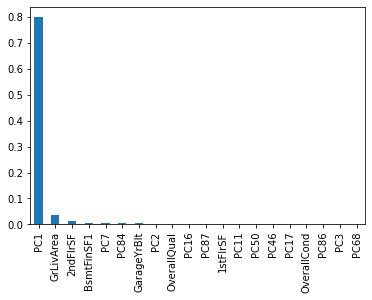

In [40]:
rf_clf = RandomForestRegressor(oob_score=True)
rf_clf.fit(houses_train_modified[feature_to_examin["kmeans_and_pca"]],houses_train["SalePrice"].values)
train_score = rf_clf.score(houses_train_modified[feature_to_examin["kmeans_and_pca"]],houses_train["SalePrice"].values)

print(f"full train data score: {train_score}")
print(f"OOB score: {rf_clf.oob_score_}")

feature_importances = pd.Series(data=rf_clf.feature_importances_, index=feature_to_examin["kmeans_and_pca"])
feature_importances.sort_values(ascending = False).head(20).plot.bar();


We can see that (unsurpisingly) by far the most important feature is the first PC created using PCA 

### Linear regression

We first want to find important features and also make sure to chose features that are somewhat independant of each other.

In [147]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import date
from sklearn.model_selection import GridSearchCV

In [82]:
features_for_lr = sorted(list(zip(pca.components_[0],cols_for_pca)),key=lambda x: -abs(x[0]))[:10]
features_name_set_one = [f[1] for f in features_for_lr]

In [83]:
houses_train_modified_copy = houses_train_modified.copy()

In [67]:
# #plot color scaled correlation matrix
# corr=houses_train_modified_copy[features_name].corr()
# corr.style.background_gradient(cmap='coolwarm')

In [84]:
#Compute VIF data for each independent variable
vif = pd.DataFrame()
vif["features"] = houses_train_modified_copy[features_name_set_one].columns
vif["vif_Factor"] = [variance_inflation_factor(houses_train_modified_copy[features_name_set_one].values, i) for i in range(houses_train_modified_copy[features_name_set_one].shape[1])]
vif

,features,vif_Factor
0,OverallQual,63.248650
1,Neighborhood_fact,10.177276
2,YearBuilt,27.008616
3,GarageCars,35.962881
4,BsmtQual_fact,23.268821
5,ExterQual_fact,19.752708
6,GarageArea,28.903789
7,GarageFinish_fact,10.853968
8,KitchenQual_fact,14.518551
9,GarageType_fact,13.207149


Generally, when VIF is higher than 10, there is significant multicollinearity that needs to be corrected.
in order to tackel this problem we will try to transform the 'YearBuilt' variable to make it less correlated but still maintain it's feature:

In [86]:
# creating the date object of today's date
todays_date = date.today()
houses_train_modified_copy['house_age'] = todays_date.year - houses_train_modified_copy['YearBuilt'] 

 removing 'YearBuilt' from features_name list and appending 'house_age'

In [87]:
features_name_set_one.remove('YearBuilt')
features_name_set_one.append('house_age')

In [89]:
vif = pd.DataFrame()
vif["features"] = houses_train_modified_copy[features_name_set_one].columns
vif["vif_Factor"] = [variance_inflation_factor(houses_train_modified_copy[features_name_set_one].values, i) for i in range(houses_train_modified_copy[features_name_set_one].shape[1])]
vif

,features,vif_Factor
0,OverallQual,57.511027
1,Neighborhood_fact,11.217980
2,GarageCars,35.996812
3,BsmtQual_fact,22.234850
4,ExterQual_fact,20.093367
5,GarageArea,28.923319
6,GarageFinish_fact,11.033404
7,KitchenQual_fact,14.543846
8,GarageType_fact,12.789404
9,house_age,4.036535


as we can see, we succeeded to reduce the VIF , but it is not enough :(

In [118]:
features_name_second_set = list(feature_importances.sort_values(ascending = False).index[:10])

In [119]:
vif = pd.DataFrame()
vif["features"] = houses_train_modified_copy[features_name_second_set].columns
vif["vif_Factor"] = [variance_inflation_factor(houses_train_modified_copy[features_name_second_set].values, i) for i in range(houses_train_modified_copy[features_name_second_set].shape[1])]
vif

,features,vif_Factor
0,PC1,4.191575
1,GrLivArea,53.354665
2,2ndFlrSF,4.550942
3,BsmtFinSF1,3.444116
4,PC7,1.436835
5,PC84,1.001965
6,GarageYrBlt,92.336516
7,PC2,1.708769
8,OverallQual,74.355386
9,PC16,1.023106


In [120]:
houses_train_modified_copy['Garage_age'] = todays_date.year - houses_train_modified_copy['GarageYrBlt'] 
features_name_second_set.remove('GarageYrBlt')
features_name_second_set.append('Garage_age')

In [122]:
vif = pd.DataFrame()
vif["features"] = houses_train_modified_copy[features_name_second_set].columns
vif["vif_Factor"] = [variance_inflation_factor(houses_train_modified_copy[features_name_second_set].values, i) for i in range(houses_train_modified_copy[features_name_second_set].shape[1])]
vif

,features,vif_Factor
0,PC1,3.879571
1,GrLivArea,43.593305
2,2ndFlrSF,4.234037
3,BsmtFinSF1,3.117987
4,PC7,1.243196
5,PC84,1.001660
6,PC2,1.908081
7,OverallQual,36.420370
8,PC16,1.034919
9,Garage_age,11.401681


since we couldn't succsess to reduce the VIF , we will use the PCA componenets for the LR model :

In [128]:
features_name_third_set  = [col for col in houses_train_modified_copy.columns if 'PC' in col]

In [159]:
X_train, X_test, y_train, y_test = train_test_split(houses_train_modified[features_name_third_set], houses_train["SalePrice"].values, test_size=0.33, random_state=42)
parametersGrid = {"max_iter": [1, 5, 10],
                  "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, cv=10)
grid.fit(X_train, y_train)

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318661691493.5163, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 288873966279.3281, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314636327978.2947, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315935659819.85516, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318642459071.1516, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 288854269200.7479, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289778046594.83026, tolerance: 524268499.97615695
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315873771855.8523, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313382323891.40643, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318584281611.14905, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 288794480723.9597, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314552690437.9789, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322389423191.524, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313316486748.85455, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280516328651.54877, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311059863188.03735, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315151041545.9681, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319452438033.7156, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311033554501.8143, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315122960165.1062, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319428226220.9749, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311006392931.1014, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315094431801.20575, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319403874933.52405, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295525371126.1432, tolerance: 490518032.3774808
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310980189653.2658, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315065340409.0266, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310520835196.01465, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256841263489.42328, tolerance: 497960506.7955887
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298174801980.2265, tolerance: 490518032.3774808
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319870871710.7823, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290077894118.93585, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315936482725.37823, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314978912454.4823, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319711373150.03723, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289921357002.3272, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319548077389.15204, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289760656952.29126, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315592137258.61914, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262889276943.108, tolerance: 497960506.7955887
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302719401382.9517, tolerance: 490518032.3774808
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317954520589.50287, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326195508241.5667, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306528410954.8287, tolerance: 524268499.97615695
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323335630109.22595, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326002424782.6517, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 306348856218.3667, tolerance: 524268499.97615695
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323084092541.22034, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308856825270.75586, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253825213544.17813, tolerance: 497960506.7955887
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296100452921.5554, tolerance: 490518032.3774808
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311183502133.7466, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315295234584.5408, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319582595270.44214, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329781822454.1137, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304367077014.41956, tolerance: 524268499.97615695
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328507646290.3654, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329056981931.7349, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303272100053.5414, tolerance: 524268499.97615695
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327416720449.8192, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320655182726.6697, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322655387829.4889, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328300935302.58466, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305063749543.18005, tolerance: 490518032.3774808
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319695511999.2559, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321793369528.013, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323698427192.6005, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215333198054.3828, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194753330523.86783, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156414955484.25912, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325484472409.10815, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298121383636.60156, tolerance: 524268499.97615695
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73371328257.14642, tolerance: 490518032.3774808
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118079040897.08331, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181369526047.16833, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243839509228.36917, tolerance: 497960506.7955887
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99249130087.55331, tolerance: 490518032.3774808
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139228092087.85413, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173613054800.65152, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255676554296.90616, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322286353391.8631, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370162511120.7617, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317271396466.9018, tolerance: 497960506.7955887
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356539813929.21844, tolerance: 490518032.3774808
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360543375272.17554, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334638471769.0741, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359562498441.96216, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364977585231.1301, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351986414426.3893, tolerance: 524268499.97615695
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355614819799.9169, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284375247416.2098, tolerance: 524268499.97615695
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355097817000.76825, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327559654498.32306, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349655990729.4755, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350465268854.54004, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357094204517.56696, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308140169562.43567, tolerance: 490518032.3774808
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326327062220.02747, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315625187292.2898, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295712102800.13904, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85788854235.97678, tolerance: 497960506.7955887
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337574645668.3247, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 687537236.7088623, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328744960496.38135, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299044027723.30914, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600795818235.7722, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 606138421697.788, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 610594625085.8451, tolerance: 524268499.97615695
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584557238874.4435, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52551282556.682556, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33076950223.151733, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 536620948935.8749, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519150700264.73267, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543677709155.2094, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61943976032.591675, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74575499958.33197, tolerance: 497960506.7955887
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8251918708.5078125, tolerance: 490518032.3774808
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465803463934.5492, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444985221201.72833, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 469425538853.60077, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35454960266.477295, tolerance: 506966400.46212447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11715778669.621948, tolerance: 519577193.15499455
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380912037477.624, tolerance: 515663732.38187
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371848443649.6112, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345661419960.76636, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370167615788.7664, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1403720954103.5083, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1419148967040.1194, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1337589162446.5498, tolerance: 497960506.7955887
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1268459858207.227, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1287262830166.0908, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1301872075265.7642, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1056474608552.6824, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1067828040400.2891, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1084295268801.9744, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 747137956391.2894, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 742535736452.9353, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 764108566506.3105, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2369108807267.937, tolerance: 524268499.97615695
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2297716420986.358, tolerance: 508132896.1857546
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2278819944334.087, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1042096965881.4072, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1520381889970.8726, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1276130804362.7075, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 690337455270.0078, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1203653958121.043, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 961073465613.6533, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 846269282117.7219, tolerance: 502881001.98187447
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1228083626529.2432, tolerance: 517626849.8486178
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1078170410778.407, tolerance: 518551090.1707745
  model = cd_fast.enet_coordinate_descent(
C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

{'mean_fit_time': array([0.00514851, 0.00329294, 0.00477209, 0.00426435, 0.00367863,
        0.00542202, 0.00444756, 0.00513854, 0.00481813, 0.00505278,
        0.00480373, 0.00607436, 0.00528455, 0.00591443, 0.00637929,
        0.0061614 , 0.00659513, 0.00624242, 0.00718532, 0.00618768,
        0.00826185, 0.00756233, 0.00639389, 0.00720892, 0.00724647,
        0.0078573 , 0.0073509 , 0.00745692, 0.00869393, 0.00828362,
        0.00916033, 0.00958378, 0.00987475, 0.00725844, 0.00819468,
        0.01089563, 0.01052372, 0.01221397, 0.01372032, 0.00952971,
        0.01165409, 0.01271107, 0.01159592, 0.01490309, 0.01851304,
        0.01911335, 0.01740251, 0.01896496, 0.0183156 , 0.01669211,
        0.01362233, 0.01271822, 0.01162789, 0.01283746, 0.01238933,
        0.0150341 , 0.01485381, 0.01253345, 0.01680529, 0.01422839,
        0.01492255, 0.01507041, 0.01381905, 0.01638229, 0.01649566,
        0.01581726, 0.01144323, 0.010776  , 0.0129921 , 0.01212387,
        0.01246796, 0.01290669,

In [168]:
df = pd.DataFrame(grid.cv_results_)
df[['param_alpha','param_l1_ratio','param_max_iter','mean_test_score','rank_test_score']].sort_values(by = 'rank_test_score')

,param_alpha,param_l1_ratio,param_max_iter,mean_test_score,rank_test_score
144,1,0.8,1,0.837415,1
141,1,0.7,1,0.837043,2
138,1,0.6,1,0.835800,3
147,1,0.9,1,0.835608,4
90,0.1,0,1,0.835592,5
...,...,...,...,...,...
184,100,0.1,5,0.191616,205
183,100,0.1,1,0.191592,207
181,100,0,5,0.175617,208
182,100,0,10,0.175617,209


In [215]:
ENclf = ElasticNet(max_iter = 1 ,alpha = 1, l1_ratio = 0.8 )
ENclf.fit(X_train ,y_train)
train_score = ENclf.score(X_train,y_train)
print(f"the score of the train set is {train_score}")
test_score = ENclf.score(X_test,y_test)
print(f"the score of the test set is {test_score}")

the score of the train set is 0.8678190615510516
the score of the test set is 0.8215974561995685


C:\Users\noybu\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447913629059.963, tolerance: 566931384.7288021
  model = cd_fast.enet_coordinate_descent(


In [216]:
ENclf.coef_

array([ 1.65409699e+04,  5.75390149e+03,  4.41405878e+03, -3.30869291e+03,
        2.50124633e+03,  1.01211066e+03,  5.23833732e+03, -2.50723010e+03,
       -7.18334144e+01,  1.68411992e+03, -1.47632721e+03, -5.56773276e+03,
       -7.88686993e+01,  7.36280830e+02, -5.84602997e+03, -7.68741401e+02,
       -3.04271552e+03, -1.18621083e+03,  1.29991427e+03,  1.22425185e+03,
       -4.74068970e+02, -2.73319564e+02,  3.47640921e+02, -3.57241396e+03,
        3.44296627e+03, -8.94314150e+02,  3.93899552e+03, -5.32511349e+02,
       -1.53029161e+03,  3.64182732e+02,  4.71694539e+02, -1.41420278e+03,
       -5.10136136e+02, -1.11112955e+03,  2.20431806e+03,  4.10261562e+03,
       -8.48240261e+02,  4.66872577e+03,  3.53753965e+03, -1.87315102e+02,
       -3.46824775e+03,  1.60886826e+03,  3.91135204e+03, -3.03100929e+03,
        3.16151282e+03,  2.41252377e+03,  1.56764776e+03, -9.78812034e+02,
       -2.31046944e+03, -3.41961618e+03,  3.09594149e+03, -2.73814022e+02,
        2.11208719e+02,  

In [171]:
test_prediction = rf_clf.predict(houses_test_modified[feature_to_examin["kmeans_and_pca"]])
test_prediction_to_upload = pd.DataFrame(data = list(zip(houses_test.Id.values,test_prediction)), columns = ["Id","SalePrice"])
test_prediction_to_upload.to_csv("./houses_SalePrice_predictions.csv",sep=",",index=False)

In [222]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

In [226]:
X_train, X_test, y_train, y_test = train_test_split(houses_train_modified[kmean_f_with_log], houses_train["SalePrice"].values, test_size=0.33, random_state=42)
# parametersGrid = {"max_iter": [1, 5, 10],
#                   "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
#                   "l1_ratio": np.arange(0.0, 1.0, 0.1)}

CBclf = CatBoostRegressor()
# grid = GridSearchCV(eNet, parametersGrid, cv=10)
CBclf.fit(X_train, y_train)
pred = CBclf.predict(X_test)

Learning rate set to 0.040799
0:	learn: 74095.3094006	total: 6.23ms	remaining: 6.22s
1:	learn: 72399.1097188	total: 10.8ms	remaining: 5.4s
2:	learn: 70696.5673054	total: 14.4ms	remaining: 4.79s
3:	learn: 68913.2985756	total: 18.1ms	remaining: 4.5s
4:	learn: 67135.0663241	total: 22.7ms	remaining: 4.51s
5:	learn: 65581.5644342	total: 26.2ms	remaining: 4.34s
6:	learn: 64061.4855252	total: 29.3ms	remaining: 4.16s
7:	learn: 62475.4791457	total: 32.9ms	remaining: 4.08s
8:	learn: 61104.6725129	total: 37.3ms	remaining: 4.11s
9:	learn: 59723.4612269	total: 40.7ms	remaining: 4.02s
10:	learn: 58454.8095412	total: 44.3ms	remaining: 3.98s
11:	learn: 57035.4219916	total: 47.9ms	remaining: 3.94s
12:	learn: 55717.5914608	total: 52.9ms	remaining: 4.01s
13:	learn: 54562.5130592	total: 56.6ms	remaining: 3.99s
14:	learn: 53294.2049629	total: 59.9ms	remaining: 3.93s
15:	learn: 52205.5360078	total: 63ms	remaining: 3.87s
16:	learn: 51045.8563323	total: 66.4ms	remaining: 3.84s
17:	learn: 50023.9602405	total: 

172:	learn: 16674.7126909	total: 873ms	remaining: 4.17s
173:	learn: 16631.0586109	total: 884ms	remaining: 4.2s
174:	learn: 16606.1419935	total: 893ms	remaining: 4.21s
175:	learn: 16598.7918140	total: 902ms	remaining: 4.22s
176:	learn: 16586.8292980	total: 906ms	remaining: 4.21s
177:	learn: 16550.9287437	total: 911ms	remaining: 4.2s
178:	learn: 16515.1128956	total: 916ms	remaining: 4.2s
179:	learn: 16487.6460223	total: 924ms	remaining: 4.21s
180:	learn: 16439.3872362	total: 931ms	remaining: 4.21s
181:	learn: 16419.0186068	total: 937ms	remaining: 4.21s
182:	learn: 16382.0397873	total: 946ms	remaining: 4.22s
183:	learn: 16338.4663467	total: 954ms	remaining: 4.23s
184:	learn: 16292.3825431	total: 963ms	remaining: 4.24s
185:	learn: 16255.7288607	total: 975ms	remaining: 4.26s
186:	learn: 16245.1578400	total: 986ms	remaining: 4.29s
187:	learn: 16201.9849867	total: 995ms	remaining: 4.29s
188:	learn: 16166.3180785	total: 1s	remaining: 4.3s
189:	learn: 16112.9175662	total: 1.01s	remaining: 4.31s

323:	learn: 12223.6096610	total: 2.1s	remaining: 4.38s
324:	learn: 12193.2144749	total: 2.13s	remaining: 4.41s
325:	learn: 12158.6945848	total: 2.14s	remaining: 4.43s
326:	learn: 12142.9561685	total: 2.15s	remaining: 4.42s
327:	learn: 12121.6637252	total: 2.16s	remaining: 4.43s
328:	learn: 12102.5518880	total: 2.17s	remaining: 4.42s
329:	learn: 12082.6164354	total: 2.17s	remaining: 4.42s
330:	learn: 12049.3367955	total: 2.18s	remaining: 4.41s
331:	learn: 12024.2244073	total: 2.19s	remaining: 4.41s
332:	learn: 11999.7804469	total: 2.2s	remaining: 4.4s
333:	learn: 11968.2455369	total: 2.21s	remaining: 4.4s
334:	learn: 11938.9571045	total: 2.21s	remaining: 4.39s
335:	learn: 11914.6542125	total: 2.22s	remaining: 4.39s
336:	learn: 11884.8340863	total: 2.23s	remaining: 4.39s
337:	learn: 11854.9858758	total: 2.24s	remaining: 4.38s
338:	learn: 11824.7001425	total: 2.24s	remaining: 4.38s
339:	learn: 11800.8276964	total: 2.25s	remaining: 4.37s
340:	learn: 11775.8046372	total: 2.26s	remaining: 4.

479:	learn: 9120.3345067	total: 3.83s	remaining: 4.15s
480:	learn: 9105.3612993	total: 3.85s	remaining: 4.15s
481:	learn: 9091.7571229	total: 3.86s	remaining: 4.15s
482:	learn: 9065.1936098	total: 3.88s	remaining: 4.15s
483:	learn: 9056.1650776	total: 3.89s	remaining: 4.15s
484:	learn: 9032.1748045	total: 3.9s	remaining: 4.14s
485:	learn: 9016.0782352	total: 3.91s	remaining: 4.14s
486:	learn: 9000.9435092	total: 3.93s	remaining: 4.14s
487:	learn: 8984.3346145	total: 3.94s	remaining: 4.14s
488:	learn: 8969.9261563	total: 3.96s	remaining: 4.13s
489:	learn: 8946.9288686	total: 3.97s	remaining: 4.13s
490:	learn: 8918.3650948	total: 3.99s	remaining: 4.13s
491:	learn: 8914.5119689	total: 4s	remaining: 4.13s
492:	learn: 8907.6440149	total: 4.02s	remaining: 4.13s
493:	learn: 8896.4644559	total: 4.03s	remaining: 4.13s
494:	learn: 8882.7836045	total: 4.05s	remaining: 4.13s
495:	learn: 8867.2223142	total: 4.06s	remaining: 4.13s
496:	learn: 8854.7398395	total: 4.08s	remaining: 4.13s
497:	learn: 88

638:	learn: 7178.3622657	total: 6.14s	remaining: 3.47s
639:	learn: 7165.0314674	total: 6.16s	remaining: 3.46s
640:	learn: 7163.6268211	total: 6.18s	remaining: 3.46s
641:	learn: 7152.6862385	total: 6.19s	remaining: 3.45s
642:	learn: 7133.0736196	total: 6.21s	remaining: 3.45s
643:	learn: 7125.9007534	total: 6.22s	remaining: 3.44s
644:	learn: 7122.6765686	total: 6.24s	remaining: 3.43s
645:	learn: 7112.1673985	total: 6.26s	remaining: 3.43s
646:	learn: 7103.0560356	total: 6.27s	remaining: 3.42s
647:	learn: 7091.9768592	total: 6.29s	remaining: 3.42s
648:	learn: 7078.2762933	total: 6.31s	remaining: 3.41s
649:	learn: 7065.6204129	total: 6.33s	remaining: 3.41s
650:	learn: 7055.9380466	total: 6.34s	remaining: 3.4s
651:	learn: 7054.9373233	total: 6.36s	remaining: 3.39s
652:	learn: 7040.3695936	total: 6.38s	remaining: 3.39s
653:	learn: 7032.5021192	total: 6.39s	remaining: 3.38s
654:	learn: 7031.3576588	total: 6.4s	remaining: 3.37s
655:	learn: 7019.3243290	total: 6.42s	remaining: 3.37s
656:	learn: 

796:	learn: 5736.4311173	total: 8.83s	remaining: 2.25s
797:	learn: 5729.1781557	total: 8.85s	remaining: 2.24s
798:	learn: 5716.8174501	total: 8.88s	remaining: 2.23s
799:	learn: 5706.2758970	total: 8.89s	remaining: 2.22s
800:	learn: 5700.8330118	total: 8.91s	remaining: 2.21s
801:	learn: 5694.3419402	total: 8.93s	remaining: 2.21s
802:	learn: 5681.6711490	total: 8.95s	remaining: 2.19s
803:	learn: 5673.2841412	total: 8.96s	remaining: 2.19s
804:	learn: 5668.7867421	total: 8.99s	remaining: 2.18s
805:	learn: 5661.4819544	total: 9.01s	remaining: 2.17s
806:	learn: 5652.6796194	total: 9.03s	remaining: 2.16s
807:	learn: 5642.8124529	total: 9.05s	remaining: 2.15s
808:	learn: 5636.8142855	total: 9.06s	remaining: 2.14s
809:	learn: 5628.7537190	total: 9.08s	remaining: 2.13s
810:	learn: 5621.1281666	total: 9.11s	remaining: 2.12s
811:	learn: 5616.0277808	total: 9.13s	remaining: 2.11s
812:	learn: 5607.4592768	total: 9.14s	remaining: 2.1s
813:	learn: 5600.0614594	total: 9.16s	remaining: 2.09s
814:	learn:

946:	learn: 4806.2387497	total: 11.1s	remaining: 622ms
947:	learn: 4794.6569839	total: 11.1s	remaining: 610ms
948:	learn: 4790.2607561	total: 11.1s	remaining: 599ms
949:	learn: 4786.5317570	total: 11.2s	remaining: 587ms
950:	learn: 4778.4039648	total: 11.2s	remaining: 575ms
951:	learn: 4772.4577757	total: 11.2s	remaining: 564ms
952:	learn: 4769.6729688	total: 11.2s	remaining: 552ms
953:	learn: 4766.4652984	total: 11.2s	remaining: 540ms
954:	learn: 4760.8886672	total: 11.2s	remaining: 528ms
955:	learn: 4753.9571533	total: 11.2s	remaining: 516ms
956:	learn: 4749.1055032	total: 11.2s	remaining: 504ms
957:	learn: 4746.2356466	total: 11.2s	remaining: 493ms
958:	learn: 4738.2802093	total: 11.2s	remaining: 481ms
959:	learn: 4733.5046390	total: 11.3s	remaining: 469ms
960:	learn: 4728.4963653	total: 11.3s	remaining: 457ms
961:	learn: 4718.5228607	total: 11.3s	remaining: 446ms
962:	learn: 4715.7458564	total: 11.3s	remaining: 434ms
963:	learn: 4708.7073074	total: 11.3s	remaining: 422ms
964:	learn

In [228]:
CBclf.score(X_train, y_train)

0.996460512382933

In [225]:
houses_train_modified[kmean_f_with_log]

,MSZoning_fact,Street_fact,Alley_fact,LotShape_fact,LandContour_fact,Utilities_fact,LotConfig_fact,LandSlope_fact,Neighborhood_fact,Condition1_fact,...,MoSold,YrSold,LotArea_log,BsmtFinSF2_log,LowQualFinSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,MiscVal_log,area_label_fact
0,3,1,2,0,1,1,0,0,16,4,...,2,2008,9.041922,-9.210340,-9.21034,-9.210340,-9.21034,-9.21034,-9.210340,1
1,3,1,2,0,1,1,1,0,20,2,...,5,2007,9.169518,-9.210340,-9.21034,-9.210340,-9.21034,-9.21034,-9.210340,1
2,3,1,2,1,1,1,0,0,16,4,...,9,2008,9.328123,-9.210340,-9.21034,-9.210340,-9.21034,-9.21034,-9.210340,2
3,3,1,2,1,1,1,2,0,17,4,...,2,2006,9.164296,-9.210340,-9.21034,5.324529,-9.21034,-9.21034,-9.210340,1
4,3,1,2,1,1,1,1,0,24,4,...,12,2008,9.565214,-9.210340,-9.21034,-9.210340,-9.21034,-9.21034,-9.210340,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,1,2,0,1,1,0,0,14,4,...,8,2007,8.976768,-9.210340,-9.21034,-9.210340,-9.21034,-9.21034,-9.210340,1
1456,3,1,2,0,1,1,0,0,13,4,...,2,2010,9.486076,5.093751,-9.21034,-9.210340,-9.21034,-9.21034,-9.210340,2
1457,3,1,2,0,1,1,0,0,17,4,...,5,2010,9.109636,-9.210340,-9.21034,-9.210340,-9.21034,-9.21034,7.334237,1
1458,3,1,2,0,1,1,0,0,10,4,...,4,2010,9.181632,6.273834,-9.21034,4.718500,-9.21034,-9.21034,-9.210340,1
